In [57]:
import os
import pandas as pd
import pdb
import time
from sklearn.preprocessing import minmax_scale

def blend(path, select_to_essemble, weights=None, minmaxscale=False, shortenname=False):
    # TODO: shortenname:
    # generate unique id for each file, and return the id:filename map
    
    if weights is not None:
        if type(weights) != dict:
            raise ValueError('weights must be a dict or None')
        sum_weight = sum(weights.values())
        if int(sum_weight*10000)+1 != 10000 and int(sum_weight) != 1: # sometimes sum can be 0.9999999999999999, which is 1 essentially
            raise ValueError('sum of weights must be 1, but you have: {}'.format(sum_weight))
        if len(select_to_essemble) != len(weights):
            raise ValueError('when weight is not None, it must have length of select_to_essemble')
    xgb_topn_repo = {}   
    cnt = 0
    for filename in os.listdir(path):
#         pdb.set_trace()
        #score += float(item.split('_')[-1])
        select = None
        if len(select_to_essemble) == 0: # if selecting any specific ones to essemble, then essemble all 
            select = filename
        else:
            if filename in select_to_essemble:
                select = filename
            else:
                continue
        print('selected: ' + select)
        tmp = pd.read_csv(path+select)
        if shortenname:
            if select.split('.')[-1] == 'gz':
                shortened_name = select.split('.')[-3].split('_')[-1]
            else:
                shortened_name = select.split('.')[-2].split('_')[-1]
            xgb_topn_repo[shortened_name] = tmp.copy()
        else:
            xgb_topn_repo[select] = tmp.copy()
#         import pdb
#         pdb.set_trace()
        if cnt == 0:
            label_cols = list(tmp.columns)
            label_cols.pop(0) # remove 'id'
            print('please check if the label_cols is right:')
            print(label_cols)
        if minmaxscale:
            tmp[label_cols] = minmax_scale(tmp[label_cols].values)  
        if weights is not None:
            tmp[label_cols] = tmp[label_cols].applymap(lambda x: x*weights[select])
        if cnt == 0:
            preds = tmp
        else:
            preds[label_cols] += tmp[label_cols]  
        cnt += 1

    print(str(cnt)+' results selected')
    if weights is None:
        preds[label_cols] = preds[label_cols].applymap(lambda x: x/cnt)
    return preds, label_cols, xgb_topn_repo, cnt

In [58]:
path = '/home/kai/data/kaggle/talkingdata/data/SUBS/FinalSub/'#'NewRnnPreds/'

select_to_essemble = []
for filename in os.listdir(path):
    if 'csv' in filename:
        select_to_essemble.append(filename)
        print(filename)

#select_to_essemble

#preds, label_cols, xgb_topn_repo, cnt = blend(path, select_to_essemble)

Blend_4_4_5271683_lb0.9817.csv.gz
lgb_best__5723574.csv.gz
catboost_1_lb0.9808.csv.gz
Blend_final11_V2__11_5648971.csv.gz
lightgbm_lb0.9817.csv.gz
catboost_2_catboost0.9808.csv.gz
nn_12AvgBlend_5716468.csv.gz
xgb_lb0.9809.csv.gz
Blend_final_V4_6_5726714.csv.gz
xgb_lb0.9810.csv.gz
catboost_lb0.9813.csv.gz
catboost_newest_nolbscore.csv.gz
Blend_final11_11_5648169.csv.gz
lightgbm_alldata_lb0.9816.csv.gz
Blend_final_V3_7_5725251.csv.gz
sub105061048am_col_lb0.9817.csv.gz
Blend_final_V5_7_5728179.csv.gz
lightgbm_1_lb0.9817.csv.gz


In [59]:
len(select_to_essemble)

18

In [60]:
import gc; gc.collect()

94941

In [61]:
preds, label_cols, xgb_topn_repo, cnt = blend(path, select_to_essemble)

selected: Blend_4_4_5271683_lb0.9817.csv.gz
please check if the label_cols is right:
['is_attributed']
selected: lgb_best__5723574.csv.gz
selected: catboost_1_lb0.9808.csv.gz
selected: Blend_final11_V2__11_5648971.csv.gz
selected: lightgbm_lb0.9817.csv.gz
selected: catboost_2_catboost0.9808.csv.gz
selected: nn_12AvgBlend_5716468.csv.gz
selected: xgb_lb0.9809.csv.gz
selected: Blend_final_V4_6_5726714.csv.gz
selected: xgb_lb0.9810.csv.gz
selected: catboost_lb0.9813.csv.gz
selected: catboost_newest_nolbscore.csv.gz
selected: Blend_final11_11_5648169.csv.gz
selected: lightgbm_alldata_lb0.9816.csv.gz
selected: Blend_final_V3_7_5725251.csv.gz
selected: sub105061048am_col_lb0.9817.csv.gz
selected: Blend_final_V5_7_5728179.csv.gz
selected: lightgbm_1_lb0.9817.csv.gz
18 results selected


In [50]:
path = '/home/kai/data/kaggle/talkingdata/data/SUBS/FinalSub/'

select_to_essemble = [
    'Blend_4_4_5271683_lb0.9817.csv.gz',
    'lgb_best__5723574.csv.gz',
#     'lightgbm_lb0.9817.csv.gz':0.15,
    'lightgbm_alldata_lb0.9816.csv.gz',
#     'lightgbm_1_lb0.9817.csv.gz':0.15,
    'sub105061048am_col_lb0.9817.csv.gz',
#     'catboost_2_catboost0.9808.csv.gz':0.07,
#     'catboost_1_lb0.9808.csv.gz':0.07,
#     'catboost_newest_nolbscore.csv.gz':0.07,
#     'xgb_lb0.9809.csv.gz',
    'xgb_lb0.9810.csv.gz',
    'catboost_lb0.9813.csv.gz',
    'nn_12AvgBlend_5716468.csv.gz'
#     'Blend_4_4_5271683_lb0.9817.csv.gz',
#     'catboost_1_lb0.9808.csv.gz',
#     'xgb_1_lb0.9809.csv.gz',
#     'lightgbm_lb0.9817.csv.gz',
#     'catboost_2_catboost0.9808.csv.gz',
#     'nn_12AvgBlend_5716468.csv.gz',
#     'catboost_newest_nolbscore.csv.gz',
#     'lightgbm_alldata_lb0.9816.csv.gz',
#     'sub105061048am_col_lb0.9817.csv.gz',
#     'xgb_2_lb0.9810.csv.gz',
#     'lightgbm_1_lb0.9817.csv.gz'
#     'all_suppelement_tree_1200_depth6_scale398_lr0.05_ntree_300_450_600_lb0.9804.csv.gz',
#     'all_suppelement_tree_1200_depth6_scale398_lr0.05_ntree_650_850_1100.csv.gz',
#     'all_suppelement_xgbtree_900_depth7_scale99_lr0.1_ntree_80_120_150_lb0.9809.csv.gz',
#     'paramsCombo_1_lr0.05_scale99_ntree500ntree_300_370_470_lb0.9816.csv.gz',
#     'Blend_3_9815_3_5216870_lb9816.csv.gz'
    #'equal_hour_blend_matrixregV5_leaf61_firsttimediff_exclude_lb0.9800.csv.gz',
    #'allday_blend_supplement_V2_attributediff_lb0.9815.csv.gz',
#     'allday_blend_supplement_V2_attributediff_noreg_lb0.9815.csv.gz',
    #'paramsCombo_1_lr0.03ntree_595_605_802_lb0.9815.csv.gz'
#     'equal_hour_blend_equalhour_supplement_V1_0.9811.csv.gz'
    #'sub_it_4513683_9778.csv.gz',
    #'wordbatch_fm_ftrl_4525246_9769.csv.gz'
]

# V2:
# 'Blend_4_4_5271683_lb0.9817.csv.gz':0.15,
#     'lightgbm_lb0.9817.csv.gz':0.15,
#     'lightgbm_alldata_lb0.9816.csv.gz':0.15,
#     'lightgbm_1_lb0.9817.csv.gz':0.15,
#     'sub105061048am_col_lb0.9817.csv.gz':0.15,
#     'catboost_2_catboost0.9808.csv.gz':0.044,
#     'catboost_1_lb0.9808.csv.gz':0.044,
#     'catboost_newest_nolbscore.csv.gz':0.044,
#     'xgb_1_lb0.9809.csv.gz':0.044,
#     'xgb_2_lb0.9810.csv.gz':0.044,
#     'nn_7AvgBlend_5561033.csv.gz':0.03

# V1:
weights = {
    'Blend_4_4_5271683_lb0.9817.csv.gz':0.1,
    'lgb_best__5723574.csv.gz':0.1,
    'lightgbm_alldata_lb0.9816.csv.gz':0.1,
    'sub105061048am_col_lb0.9817.csv.gz':0.1,
    'xgb_lb0.9810.csv.gz':0.2,
    'catboost_lb0.9813.csv.gz':0.2,
    'nn_12AvgBlend_5716468.csv.gz':0.2
#     'all_suppelement_tree_1200_depth6_scale398_lr0.05_ntree_300_450_600_lb0.9804.csv.gz':0.15,
#     'all_suppelement_tree_1200_depth6_scale398_lr0.05_ntree_650_850_1100.csv.gz':0.2,
#     'all_suppelement_xgbtree_900_depth7_scale99_lr0.1_ntree_80_120_150_lb0.9809.csv.gz':0.2,
#     'paramsCombo_1_lr0.05_scale99_ntree500ntree_300_370_470_lb0.9816.csv.gz':0.3,
#     'Blend_3_9815_3_5216870_lb9816.csv.gz':0.3,
#     'allday_blend_supplement_V2_attributediff_lb0.9815.csv.gz':0.5,
#     'allday_blend_supplement_V2_attributediff_noreg_lb0.9815.csv.gz':0.25,
#     'paramsCombo_1_lr0.03ntree_595_605_802_lb0.9815.csv.gz':0.5
#     'equal_hour_blend_equalhour_supplement_V1_0.9811.csv.gz':0.4
#     'equal_hour_blend_matrixregV5_leaf61_firsttimediff_exclude_lb0.9800.csv.gz':0.7,
#     'sub_it_4513683_9778.csv.gz':0.3,
    #'wordbatch_fm_ftrl_4525246_9769.csv.gz':0.2
}

preds, label_cols, xgb_topn_repo, cnt = blend(path, select_to_essemble, weights)#, shortenname=True)

selected: Blend_4_4_5271683_lb0.9817.csv.gz
please check if the label_cols is right:
['is_attributed']
selected: lgb_best__5723574.csv.gz
selected: nn_12AvgBlend_5716468.csv.gz
selected: xgb_lb0.9810.csv.gz
selected: catboost_lb0.9813.csv.gz
selected: lightgbm_alldata_lb0.9816.csv.gz
selected: sub105061048am_col_lb0.9817.csv.gz
7 results selected


In [43]:
preds.head(3)

,click_id,is_attributed
0,0,0.094338
1,1,0.012099
2,2,0.001665


In [35]:
preds.head(3)

,click_id,is_attributed
0,0,0.098217
1,1,0.013295
2,2,0.001862


In [51]:
preds.head(3)

,click_id,is_attributed
0,0,0.105463
1,1,0.014878
2,2,0.002081


In [19]:
preds.head(3)

,click_id,is_attributed
0,0,0.129513
1,1,0.019085
2,2,0.002747


In [14]:
list(xgb_topn_repo)

['Blend_4_4_5271683_lb0.9817.csv.gz',
 'catboost_1_lb0.9808.csv.gz',
 'xgb_1_lb0.9809.csv.gz',
 'lightgbm_lb0.9817.csv.gz',
 'catboost_2_catboost0.9808.csv.gz',
 'nn_7AvgBlend_5561033.csv.gz',
 'catboost_newest_nolbscore.csv.gz',
 'lightgbm_alldata_lb0.9816.csv.gz',
 'sub105061048am_col_lb0.9817.csv.gz',
 'xgb_2_lb0.9810.csv.gz',
 'lightgbm_1_lb0.9817.csv.gz']

In [32]:
import sys
sys.path.append('/home/kai/data/shiyi/Kaggle/toxic/sc/stacking')
from toxic_utils import scatter_per_label
import matplotlib.pyplot as plt
%matplotlib inline

is_attributed
['Blend_4_4_5271683_lb0.9817.csv.gz', 'lgb_best__5723574.csv.gz', 'nn_12AvgBlend_5716468.csv.gz', 'xgb_lb0.9810.csv.gz', 'catboost_lb0.9813.csv.gz', 'lightgbm_alldata_lb0.9816.csv.gz', 'sub105061048am_col_lb0.9817.csv.gz']


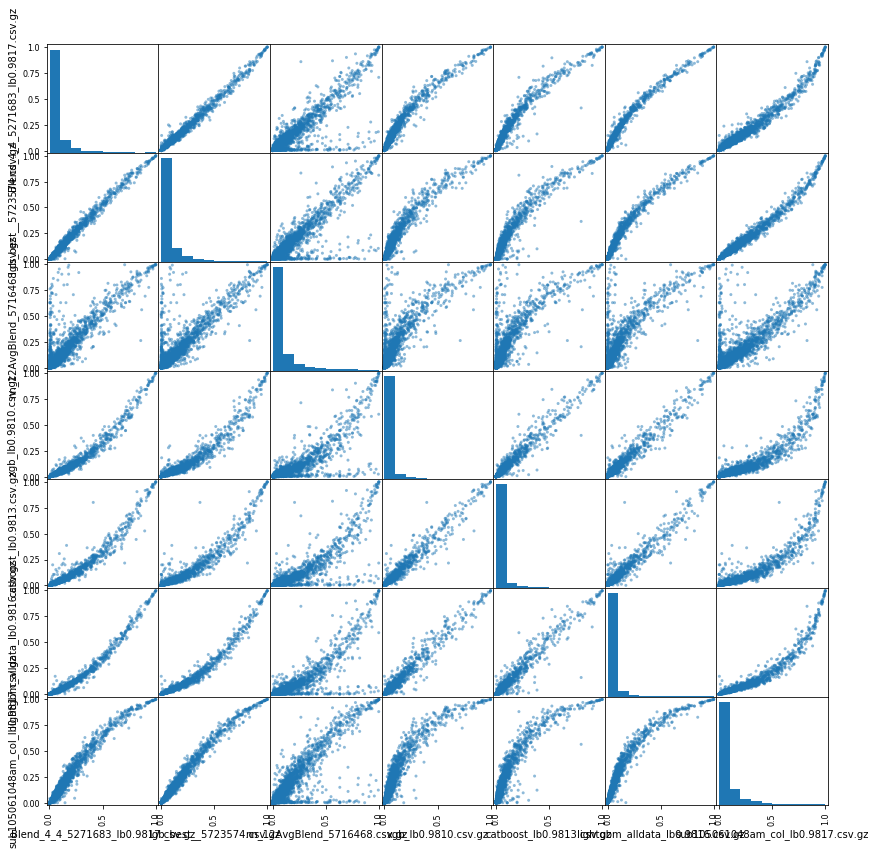

In [52]:
scatter_per_label(xgb_topn_repo, 'is_attributed', 5000)

In [7]:
list(xgb_topn_repo)

['allday_blend_supplement_V2_attributediff_lb0.9815.csv.gz',
 'allday_blend_supplement_V2_attributediff_noreg_lb0.9815.csv.gz',
 'paramsCombo_1_lr0.03ntree_595_605_802_lb0.9815.csv.gz']

In [23]:
tempid = ''
for selected in select_to_essemble:
    temp = selected.split('_')[-1].split('.')[0]
    if len(temp) > 7:
        temp = temp[3:]
    print(temp)
    tempid += temp + '_'
print(tempid)

1100
lb0
lb0
lb9816
1100_lb0_lb0_lb9816_


In [10]:
preds.tail()

,click_id,is_attributed
18790464,18790464,0.450775
18790465,18790465,0.001221
18790466,18790467,0.059170
18790467,18790466,0.063150
18790468,18790468,0.014700


In [19]:
import numpy as np

In [38]:
map3_t = np.load('/home/kai/data/kaggle/talkingdata/data/idx_to_0.npy')

In [53]:
preds.loc[map3_t, 'is_attributed'].mean(), preds.loc[map3_t, 'is_attributed'].max()

(0.047423982145847324, 0.99877637986969048)

In [54]:
preds.loc[map3_t, 'is_attributed'] = 0

In [55]:
preds.loc[map3_t, 'is_attributed'].mean(), preds.loc[map3_t, 'is_attributed'].max()

(0.0, 0.0)

In [56]:
essemble_name = 'Blend_final_V5' 
tempid = str(int(time.time()))[3:]
print(tempid)
preds.to_csv(path+essemble_name+'_{}_{}.csv.gz'.format(cnt, tempid), index=False, float_format='%.9f', compression='gzip')

5728179
